<a href="https://colab.research.google.com/github/firesinger/oceanography/blob/main/Conda_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time series Analysis Progms
1. Tide Analysis with Python & R
2. Julia & Fortran

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

# Set package path, revise path case by project
my_path = '/content/drive/MyDrive/additional_package'
import sys
sys.path.insert(0, '/content/drive/MyDrive/additional_package')

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
import condacolab
condacolab.check()

In [ ]:
! conda env create -f '/content/drive/MyDrive/Colab Notebooks/environment.yml'

In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import utide

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/can1998.dtf') as f:
    lines = f.readlines()
print(''.join(lines[:30]))

In [ ]:
def date_parser(year, month, day, hour):
    year, month, day, hour = map(int, (year, month, day, hour))
    return datetime.datetime(year, month, day, hour)

# Names of the columns that will be used to make a "datetime" column:
parse_dates = dict(datetime=['year', 'month', 'day','hour'])

# Names of the original columns in the file, including only
# the ones we will use; we are skipping the first, which appears
# to be seconds from the beginning.
names = ['year', 'month', 'day', 'hour', 'elev', 'flag']

obs = pd.read_table('/content/drive/MyDrive/Colab Notebooks/can1998.dtf',
                    names=names,
                    skipinitialspace=True,
                    delim_whitespace=True,
                    index_col='datetime',
                    usecols=range(1, 7),
                    na_values='9.990',
                    parse_dates=parse_dates,
                    date_parser=date_parser,
                   )
obs.head(6)

In [ ]:
bad = obs['flag'] == 2
corrected = obs['flag'] == 1

obs.loc[bad, 'elev'] = np.nan
obs['anomaly'] = obs['elev'] - obs['elev'].mean()
obs['anomaly'] = obs['anomaly'].interpolate()
print('{} points were flagged "bad" and interpolated'.format(bad.sum()))
print('{} points were flagged "corrected" and left unchanged'.format(corrected.sum()))

In [ ]:
time = mdates.date2num(obs.index.to_pydatetime())

coef = utide.solve(time, obs['anomaly'].values,
                   lat=-25,
                   method='ols',
                   conf_int='MC')

In [ ]:
tide = utide.reconstruct(time, coef)

In [ ]:
print(tide.keys())

In [ ]:
#t = obs.index.values  # dtype is '<M8[ns]' (numpy datetime64)
# It is more efficient to supply the time directly as matplotlib
# datenum floats:
t = tide.t_mpl

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True)

ax0.plot(t, obs.anomaly, label=u'Observations', color='C0')
ax1.plot(t, tide.h, label=u'Tide Fit', color='C1')
ax2.plot(t, obs.anomaly - tide.h, label=u'Residual', color='C2')
ax2.xaxis_date()
fig.legend(ncol=3, loc='upper center')
fig.autofmt_xdate()

In [ ]:
def fake_tide(t, M2amp, M2phase):
    """
    Generate a minimally realistic-looking fake semidiurnal tide.
    
    t is time in hours
    phases are in radians
    
    Modified from: http://currents.soest.hawaii.edu/ocn760_4/_static/plotting.html
    """
    return M2amp * np.sin(2 * np.pi * t / 12.42 - M2phase)

In [ ]:
from pandas import date_range

N = 500

t = date_range(start='2016-03-29', periods=N, freq='H')

# Signal + some noise.
u = fake_tide(np.arange(N), M2amp=2, M2phase=0) + np.random.randn(N)
v = fake_tide(np.arange(N), M2amp=1, M2phase=np.pi) + np.random.randn(N)

In [ ]:
from matplotlib.dates import date2num

time = date2num(t.to_pydatetime())

In [ ]:
from utide import solve

coef = solve(time, u, v,
             lat=-42.5,
             nodal=False,
             trend=False,
             method='ols',
             conf_int='linear',
             Rayleigh_min=0.95,)

In [ ]:
from utide import reconstruct

tide = reconstruct(time, coef)

In [ ]:
tide.keys()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-notebook')

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(t, u, label=u'Observations')
ax0.legend(numpoints=1, loc='lower right')

ax1.plot(t, tide['u'], alpha=0.5, label=u'Prediction')
ax1.legend(numpoints=1, loc='lower right')

ax2.plot(t, u-tide['u'], alpha=0.5, label=u'Residue')
_ = ax2.legend(numpoints=1, loc='lower right')

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(t, v, label=u'Observations')
ax0.legend(numpoints=1, loc='lower right')

ax1.plot(t, tide['v'], alpha=0.5, label=u'Prediction')
ax1.legend(numpoints=1, loc='lower right')

ax2.plot(t, v-tide['v'], alpha=0.5, label=u'Residue')
_ = ax2.legend(numpoints=1, loc='lower right')

In [ ]:
from rpy2.robjects import r

In [ ]:
%%R
R.version

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
remotes::install_github("dankelley/oce", ref="develop")

In [100]:
%%R
if (!require(SWMPr)) install.packages("SWMPr")
if (!require(TideHarmonics)) install.packages("TideHarmonics")

R[write to console]: Loading required package: TideHarmonics

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/TideHarmonics_0.1-1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1229446 bytes (1.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[writ

In [101]:
%%R
library(oce)
library(SWMPr)
library(TideHarmonics)

In [106]:
%%R
# clean, one hour time step, subset, fill gaps
dat <- qaqc(apadbwq) %>% 
  setstep(timestep = 60) %>% 
  subset(subset = c('2013-01-01 0:0', '2013-12-31 0:0'), select = 'depth') %>% 
  na.approx(maxgap = 1e6)

In [ ]:
%%R
dat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
3573 2013-05-29 20:00:00 1.6100
3574 2013-05-29 21:00:00 1.5600
3575 2013-05-29 22:00:00 1.4800
3576 2013-05-29 23:00:00 1.3900
3577 2013-05-30 00:00:00 1.3100
3578 2013-05-30 01:00:00 1.2600
3579 2013-05-30 02:00:00 1.2000
3580 2013-05-30 03:00:00 1.2600
3581 2013-05-30 04:00:00 1.3400
3582 2013-05-30 05:00:00 1.4200
3583 2013-05-30 06:00:00 1.5200
3584 2013-05-30 07:00:00 1.6000
3585 2013-05-30 08:00:00 1.6600
3586 2013-05-30 09:00:00 1.6900
3587 2013-05-30 10:00:00 1.6900
3588 2013-05-30 11:00:00 1.6700
3589 2013-05-30 12:00:00 1.6500
3590 2013-05-30 13:00:00 1.6300
3591 2013-05-30 14:00:00 1.6100
3592 2013-05-30 15:00:00 1.5600
3593 2013-05-30 16:00:00 1.5300
3594 2013-05-30 17:00:00 1.5700
3595 2013-05-30 18:00:00 1.6000
3596 2013-05-30 19:00:00 1.6600
3597 2013-05-30 20:00:00 1.6700
3598 2013-05-30 21:00:00 1.6400
3599 2013-05-30 22:00:00 1.5700
3600 2013-05-30 23:00:00 1.5000
3601 2013-05-31 00:00:00 1.4300
3602 2013-05-31 01:00:00 1.3900
3603

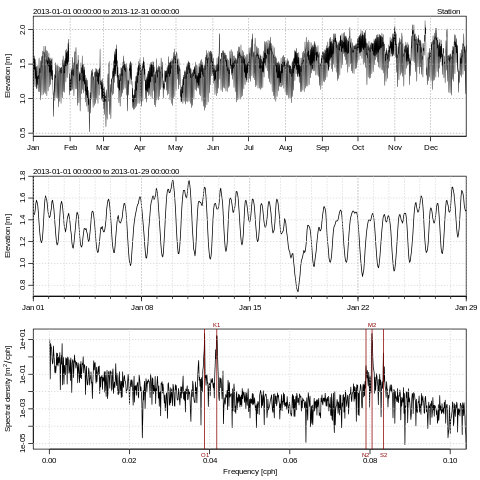

In [94]:
%%R
datsl <- as.sealevel(elevation = dat$depth, time = dat$datetimestamp)
plot(datsl)

In [95]:
%%R
# tidal components to estimate
constituents <- c('M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1')
 
# loop through tidal components, predict each with tidem
preds <- sapply(constituents, function(x){
   
    mod <- tidem(t = datsl, constituent = x)
    pred <- predict(mod)
    pred - mean(pred)
     
  }) 
 
# combine prediction, sum, add time data
predall <- rowSums(preds) + mean(datsl[['elevation']])
preds <- data.frame(time = datsl[['time']], preds, Estimated = predall) 
 
head(preds)

                 time          M2           S2           N2           K2
1 2013-01-01 00:00:00 -0.11098020 -0.020499867 0.0009915824 -0.004534663
2 2013-01-01 01:00:00 -0.11746242 -0.008651659 0.0072804771 -0.009112819
3 2013-01-01 02:00:00 -0.09451141  0.005515382 0.0118116728 -0.011236000
4 2013-01-01 03:00:00 -0.04787620  0.018205210 0.0134915071 -0.010332254
5 2013-01-01 04:00:00  0.01076148  0.026017595 0.0119145303 -0.006645036
6 2013-01-01 05:00:00  0.06671338  0.026859216 0.0074613661 -0.001167626
             K1         O1            P1 Estimated
1  0.0914568529 0.01428656  0.0385308817  1.467530
2  0.0649643288 0.04077637  0.0344303475  1.470503
3  0.0340197907 0.06485774  0.0279958775  1.496732
4  0.0007435545 0.08511160  0.0196635859  1.537286
5 -0.0325842960 0.10034441  0.0099982174  1.578085
6 -0.0636801407 0.10965853 -0.0003451308  1.603778


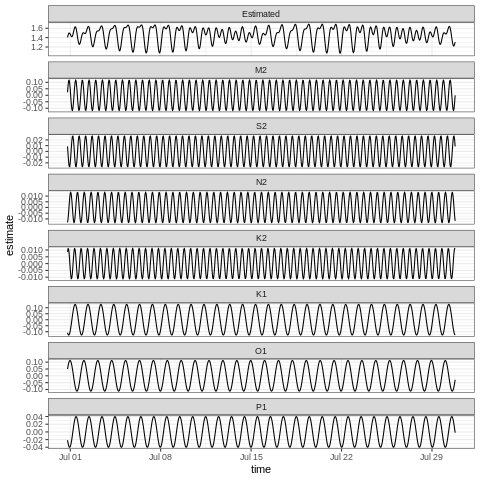

In [96]:
%%R
# prep for plot
toplo <- preds %>% 
  gather('component', 'estimate', -time) %>% 
  mutate(component = factor(component, level = c('Estimated', constituents)))
 
# plot two weeks
ggplot(toplo, aes(x = time, y = estimate, group = component)) + 
  geom_line() + 
  scale_x_datetime(limits = as.POSIXct(c('2013-07-01', '2013-07-31'))) + 
  facet_wrap(~component, ncol = 1, scales = 'free_y') + 
  theme_bw() 

In [97]:
%%R
# estimate all components together
mod <- tidem(t = datsl)
 
# get components of interest
amps <- data.frame(mod@data[c('name', 'amplitude')]) %>% 
  filter(name %in% constituents) %>% 
  arrange(amplitude)
amps

Note: the tidal record is too short to fit for constituents:  SA PI1 S1 PSI1 GAM2 H1 H2 T2 R2 
  name  amplitude
1   K2 0.01091190
2   N2 0.01342395
3   S2 0.02904518
4   P1 0.04100388
5   O1 0.11142455
6   M2 0.12005114
7   K1 0.12865764


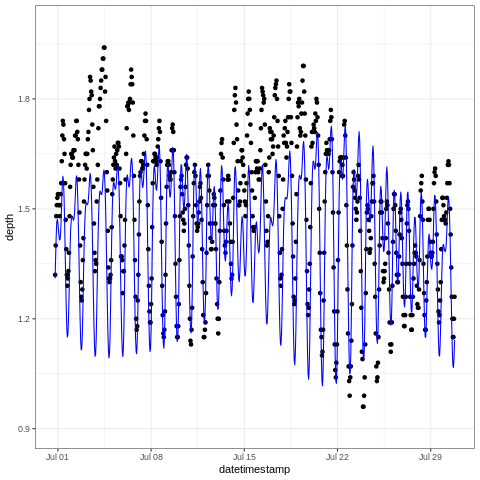

In [98]:
%%R
# add predictions to observed data
dat$Estimated <- predict(mod)
 
# plot one month
ggplot(dat, aes(x = datetimestamp, y = depth)) + 
  geom_point() + 
  geom_line(aes(y = Estimated), colour = 'blue') + 
  scale_x_datetime(limits = as.POSIXct(c('2013-07-01', '2013-07-31'))) + 
  scale_y_continuous(limits = c(0.9, 2)) +
  theme_bw() 

Note: the tidal record is too short to fit for constituents:  SA PI1 S1 PSI1 GAM2 H1 H2 T2 R2 


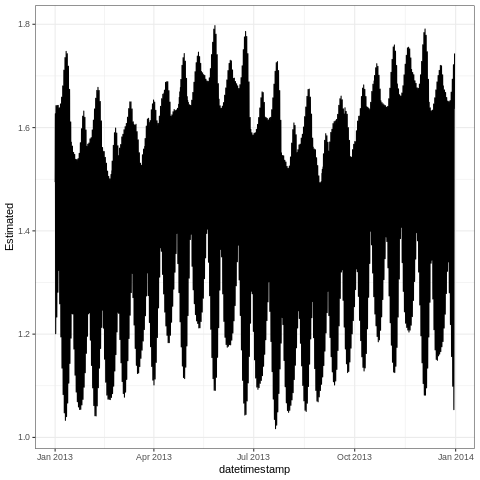

In [99]:
%%R
# clean input data, one hour time step, subset, fill gaps
dat <- qaqc(apadbwq) %>% 
  setstep(timestep = 60) %>% 
  subset(., subset = c('2013-01-01 0:0', '2013-12-31 0:0'), select = 'depth') %>% 
  na.approx(maxgap = 1e6)
 
# get model
datsl <- as.sealevel(elevation = dat$depth, time = dat$datetimestamp)
mod <- tidem(t = datsl)
 
# add predictions to observed data
dat$Estimated <- predict(mod)
 
# plot
ggplot(dat, aes(x = datetimestamp, y = Estimated)) + 
  geom_line() +
  theme_bw() 
